# Ejercicio 1

### Introduccion

El dataset que subimos consiste en un diccionario que consta de tres elementos:

`tiempos_disparos` es una lista de 1000 elementos. Cada elemento corresponde a los tiempos de disparo de una neurona (unidades en $s$).

`velocidades` es un vector con valores de velocidad en el tiempo (unidades en $m/s$).

`tiempos_velocidades` es un vector de tiempos correspondiente a cada valor de velocidad (unidades en $s$).

El dataset fue simulado generando un vector de velocidad de forma aleatoria (de tipo *random walk* gaussiano) y trenes de disparos independientes provenientes de un proceso de Poisson no estacionario (para quienes le interese, ya lo vamos a ver pero [aca](https://elephant.readthedocs.io/en/latest/index.html) pueden aprender de una libreria muy piola para hacerlo). Esto ultimo quiere decir que generamos disparos de neuronas independientes mediante distribuciones de Poisson cuyas medias de disparo $\lambda$ variaban en el tiempo en funcion de la velocidad $v$ siguiendo un modelo mas o menos como este



$$\lambda_i(v) = r_i + \alpha_i\left[v-v_{i}^{th}\right]^+ $$

donde la operacion $[\alpha]^+=\alpha$ si $\alpha>0$ y $[\alpha]^+=0$ si $\alpha<0$. Lo importante es que es un modelo de respuesta lineal a la velocidad, algo relativamente verosimil a lo que se ve en varios tipos de neuronas que codifican velocidad en distintas partes del cerebro (aunque bastante muy de juguete).

La idea de este ejercicio es que sea bastante guiado para que tengan un primer appoach algo metodico para ver y aplicar PCA, pero la posta va a estar en el ejercicio 2.

### Importamos librerias utiles (pueden usar las que quieran)

In [1]:
import numpy as np
import matplotlib.pylab as plt

#### Primero, descarguen la data y carguenla en el notebook.

In [2]:
import pickle
mypath = '/Users/Maxy/Desktop/Computational Neuroscience/Computational-Neuroscience/Ej1/'

with open(mypath+'DataTP1.pkl', 'rb') as fp:
    data = pickle.load(fp)

In [4]:
tiempos_disparos = data['tiempos_disparos']
tiempos_velocidades = data['tiempos_velocidades']
velocidades = data['velocidades']

## Inciso (a)

- Realizar un rasterplot de los trenes de disparo en el tiempo
- Visualizar velocidad vs. tiempo

Primer elemento: 
<class 'numpy.ndarray'>
(4302,)
Número de neuronas: 1000
Número de disparos para las 1ras diez neuronas: [4302, 508, 177, 1821, 2363, 3225, 2410, 4288, 1347, 2155]
51.6% de las neuronas disparan menos que la media


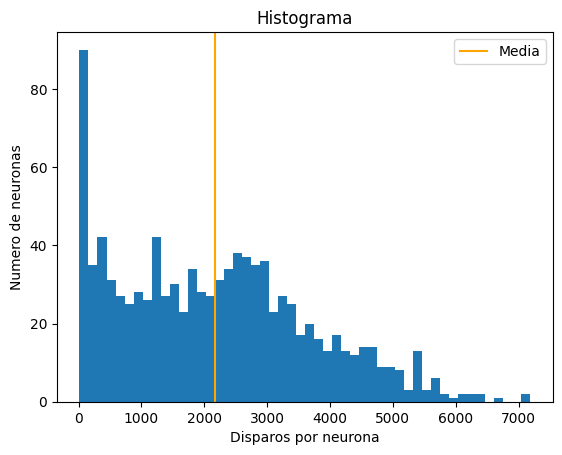

In [58]:
idx = 0
print('Primer elemento: ',
  type(tiempos_disparos[idx]),
  tiempos_disparos[idx].shape,
  sep="\n",
)

n_neurons = len(tiempos_disparos)
total_spikes_per_neuron = [len(spike_times_i) for spike_times_i in tiempos_disparos]

print(f"Número de neuronas: {n_neurons}")
print(f"Número de disparos para las 1ras diez neuronas: {total_spikes_per_neuron[:10]}")

#Analizamos la distribucion de disparos entre neuronas a continuacion 

mean_spike_count = np.mean(total_spikes_per_neuron)
frac_below_mean = (total_spikes_per_neuron < mean_spike_count).mean()

plt.hist(total_spikes_per_neuron, bins=50, histtype="stepfilled")
plt.xlabel("Disparos por neurona")
plt.ylabel("Numero de neuronas")
plt.title('Histograma')
plt.axvline(mean_spike_count, color="orange", label="Media")
plt.legend()


print(f"{frac_below_mean:2.1%} de las neuronas disparan menos que la media")

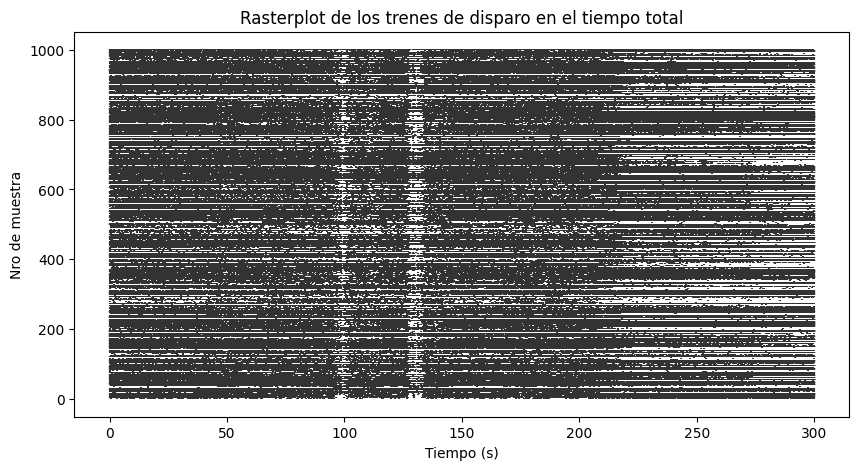

In [57]:
#Rasterplot

plt.figure(figsize=(10, 5))
for i, tiempos_disparo in enumerate(tiempos_disparos):
    plt.eventplot(tiempos_disparo, lineoffsets=i + 1, colors='.2')
plt.xlabel('Tiempo (s)')
plt.ylabel('Nro de muestra')
plt.title('Rasterplot de los trenes de disparo en el tiempo total')
plt.show()

In [52]:
print(tiempos_velocidades.shape)
print(velocidades.shape)

(30001,)
(30001,)


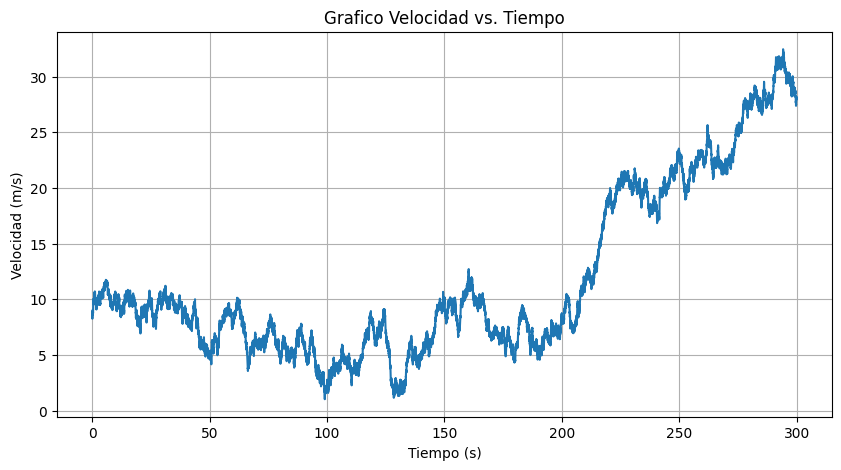

In [59]:
# Visualización de velocidad vs. tiempo
plt.figure(figsize=(10, 5))
plt.plot(tiempos_velocidades, velocidades)
plt.xlabel('Tiempo (s)')
plt.ylabel('Velocidad (m/s)')
plt.title('Grafico Velocidad vs. Tiempo')
plt.grid(True)  # Añadir cuadrícula
plt.show()

## Inciso (b)

Pasar los disparos a tasas de disparo realizando un promedio móvil con una ventana temporal adecuada



In [61]:
#@title Hint

#La idea aca es que bineen la data y sumen la cantidad de disparos por cada bin
#temporal (y lo mismo con el vector de velocidades). Hay muchas formas de hacer-
#lo, aca les dejamos una

#(1) Definan un bin temporal que les parezca razonable. La data esta en segundos,
#asi que una forma de estimar el sampling rate de los datos es calculando la
#media de la diferencia entre tiempos de mediciones consecutivas
dt = np.mean(np.diff(tiempos_velocidades))

N = len(tiempos_disparos) #numero de neuronas

#dado que el dt es de 10ms, promediar de a un segundo nos garantiza juntar varios
#disparos por bin
ancho_bin = 1

#Como los tiempos de las velocidades estan equiespaciados, los sampleamos con el
#ancho elegido
bin_tiempos_velocidades = tiempos_velocidades[::int(ancho_bin/dt)]
bin_velocidades = [np.mean(velocidades[i*int(ancho_bin/dt):(i+1)*int(ancho_bin/dt)]) for i in range(len(bin_tiempos_velocidades)-1)] #velocidad media por bin

#Calculamos y almacenamos las tasas de disparo en una matriz
tasa_disparo = np.zeros((N,len(bin_tiempos_velocidades)-1))
for n in range(tasa_disparo.shape[0]):
  tasa_disparo[n,:], _ = np.histogram(tiempos_disparos[n], bins=bin_tiempos_velocidades)

### Inciso (c)

Usando los datos del punto (b), visualizar la respuesta de las neuronas a las distintas velocidades ¿Todas responden de la misma forma?

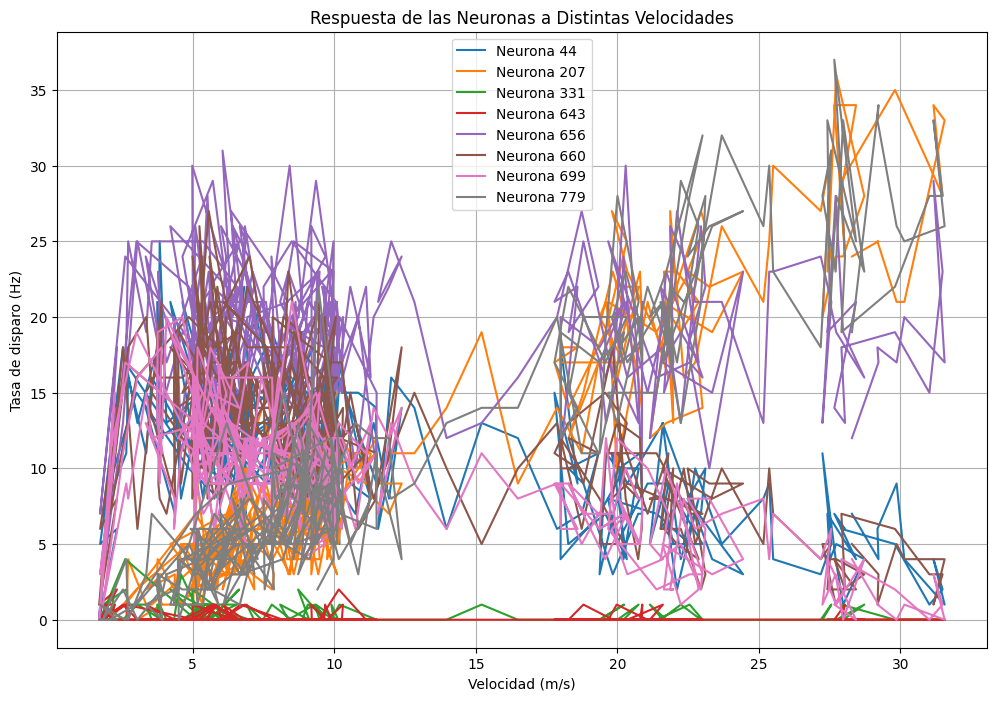

In [65]:
#Fijate en estas neuronas
indices_de_neuronas = [44, 207, 331, 643, 656, 660, 699, 779]

plt.figure(figsize=(12, 8))

for idx in indices_de_neuronas:
    plt.plot(bin_velocidades, tasa_disparo[idx], label=f'Neurona {idx}')

plt.xlabel('Velocidad (m/s)')
plt.ylabel('Tasa de disparo (Hz)')
plt.title('Respuesta de las Neuronas a Distintas Velocidades')
plt.legend()
plt.grid(True)
plt.show()

### Inciso (d)

Aplicar PCA sobre los datos del punto b y graficar la varianza explicada cumulativa ¿Cuántas dimensiones esperas que sean necesarias para capturar la dinámica relevante del problema?


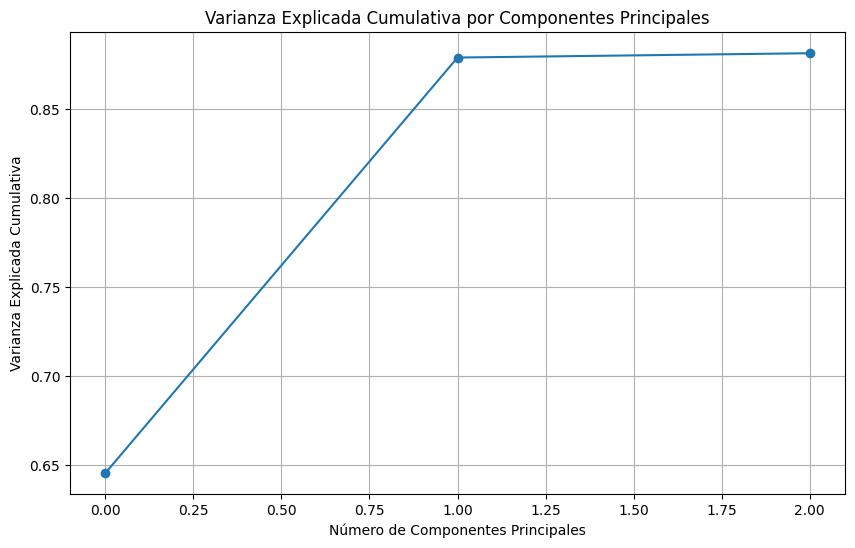

In [70]:
from sklearn.decomposition import PCA

# Aplicar PCA
pca = PCA(3)
pca.fit(tasa_disparo)

# Graficar la varianza explicada cumulativa
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Cumulativa')
plt.title('Varianza Explicada Cumulativa por Componentes Principales')
plt.grid(True)
plt.show()

### Inciso (e)

Visualizar en 2D
 - PC1 vs. PC2
 - PC1 vs. Velocidad
 - PC1 vs. tiempo

¿Tiene sentido en base a lo esperado?